# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.60KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

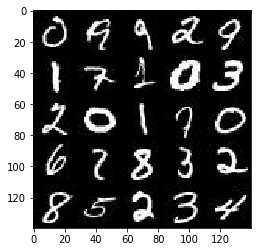

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

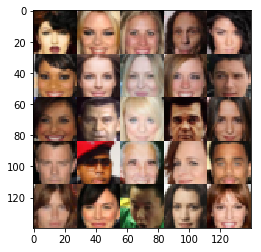

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        filter_size = 5
        alpha = 0.2
        # 28x28x3 to 56*56*64
        x1 = tf.layers.conv2d(images, 64, filter_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 56*56*64 to 112*112*128
        x2 = tf.layers.conv2d(relu1, 128, filter_size, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
        
        # 112*112*128 to 224*224*256
        x3 = tf.layers.conv2d(relu2, 256, filter_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [73]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        # 28*28*3 to 3*3*512
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # 3*3*512 to 6*6*256
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 6*6*256 to 12*12*128
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 6, strides=2, padding='valid')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    variables = tf.trainable_variables()
    d_vars = [var for var in variables if var.name.startswith('discriminator')]
    g_vars = [var for var in variables if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [83]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    print_every = 10
    show_every = 100
    #saver = tf.train.Saver()    
    
    image_channels = 3 if 'RGB' == data_image_mode else 1
    inputs_real, inputs_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, 10, inputs_z, image_channels, data_image_mode)
          
        #saver.save(sess, './checkpoints/generator.ckpt')      
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 0.3210... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 5.0849
Epoch 1/2... Discriminator Loss: 2.2392... Generator Loss: 0.1879
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 5.0164
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 2.4650
Epoch 1/2... Discriminator Loss: 0.4843... Generator Loss: 1.6731
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 0.5437... Generator Loss: 2.3728
Epoch 1/2... Discriminator Loss: 0.3878... Generator Loss: 2.1734


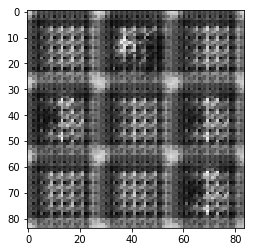

Epoch 1/2... Discriminator Loss: 0.2157... Generator Loss: 2.3614
Epoch 1/2... Discriminator Loss: 0.3581... Generator Loss: 1.6117
Epoch 1/2... Discriminator Loss: 0.2819... Generator Loss: 2.5471
Epoch 1/2... Discriminator Loss: 0.3061... Generator Loss: 1.5702
Epoch 1/2... Discriminator Loss: 0.1716... Generator Loss: 2.0376
Epoch 1/2... Discriminator Loss: 0.2339... Generator Loss: 2.0775
Epoch 1/2... Discriminator Loss: 0.4792... Generator Loss: 8.6508
Epoch 1/2... Discriminator Loss: 0.1760... Generator Loss: 3.0414
Epoch 1/2... Discriminator Loss: 0.1492... Generator Loss: 2.6268
Epoch 1/2... Discriminator Loss: 0.3194... Generator Loss: 6.4001


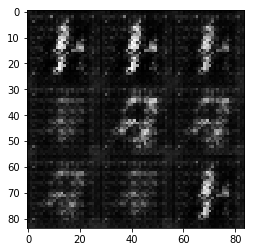

Epoch 1/2... Discriminator Loss: 0.1361... Generator Loss: 2.4296
Epoch 1/2... Discriminator Loss: 0.1084... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 0.1052... Generator Loss: 2.8689
Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 4.1467
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 1.6891
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 1.8727
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 0.2215... Generator Loss: 2.8272
Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 0.6580


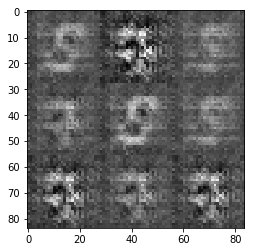

Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 4.3334
Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 2.4906
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 3.1523
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.6852
Epoch 1/2... Discriminator Loss: 0.5033... Generator Loss: 2.9102
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 4.7241
Epoch 1/2... Discriminator Loss: 0.4737... Generator Loss: 1.4342
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 2.0617


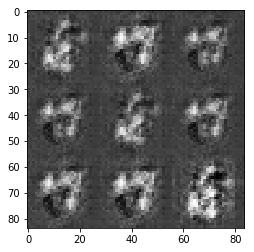

Epoch 1/2... Discriminator Loss: 0.3090... Generator Loss: 1.9854
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 4.0664
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 6.2098
Epoch 1/2... Discriminator Loss: 0.3229... Generator Loss: 2.5784
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 1.6500
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 4.9978
Epoch 2/2... Discriminator Loss: 0.2439... Generator Loss: 2.8635
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 2.0749
Epoch 2/2... Discriminator Loss: 0.2193... Generator Loss: 2.1762
Epoch 2/2... Discriminator Loss: 0.2598... Generator Loss: 2.1861


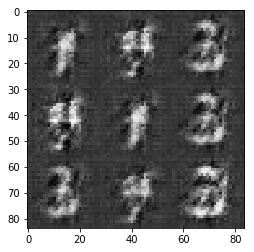

Epoch 2/2... Discriminator Loss: 0.3189... Generator Loss: 2.0648
Epoch 2/2... Discriminator Loss: 0.2723... Generator Loss: 2.1637
Epoch 2/2... Discriminator Loss: 0.3085... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 0.2034... Generator Loss: 2.8543
Epoch 2/2... Discriminator Loss: 0.3124... Generator Loss: 1.6541
Epoch 2/2... Discriminator Loss: 0.1261... Generator Loss: 3.2535
Epoch 2/2... Discriminator Loss: 0.1638... Generator Loss: 4.5231
Epoch 2/2... Discriminator Loss: 0.2078... Generator Loss: 7.4473
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 4.3421
Epoch 2/2... Discriminator Loss: 0.2257... Generator Loss: 2.0277


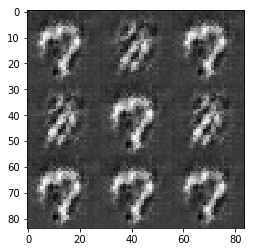

Epoch 2/2... Discriminator Loss: 0.3478... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 0.1196... Generator Loss: 3.2419
Epoch 2/2... Discriminator Loss: 0.4930... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 0.0769... Generator Loss: 3.6630
Epoch 2/2... Discriminator Loss: 0.1438... Generator Loss: 3.7763
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 3.4911
Epoch 2/2... Discriminator Loss: 0.1451... Generator Loss: 2.7341
Epoch 2/2... Discriminator Loss: 0.1555... Generator Loss: 5.3474
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 3.5206
Epoch 2/2... Discriminator Loss: 0.1796... Generator Loss: 2.7469


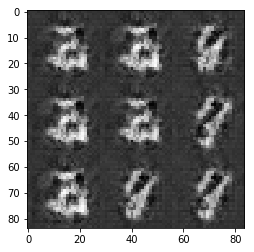

Epoch 2/2... Discriminator Loss: 0.3029... Generator Loss: 1.8547
Epoch 2/2... Discriminator Loss: 0.1009... Generator Loss: 3.8101
Epoch 2/2... Discriminator Loss: 0.2866... Generator Loss: 1.5507
Epoch 2/2... Discriminator Loss: 0.1638... Generator Loss: 2.5273
Epoch 2/2... Discriminator Loss: 0.1698... Generator Loss: 2.5161
Epoch 2/2... Discriminator Loss: 0.1232... Generator Loss: 2.9624
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.1940... Generator Loss: 2.4025
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 5.5026
Epoch 2/2... Discriminator Loss: 0.1366... Generator Loss: 2.8661


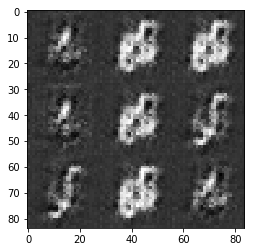

Epoch 2/2... Discriminator Loss: 0.2615... Generator Loss: 4.1679
Epoch 2/2... Discriminator Loss: 0.1756... Generator Loss: 2.9509
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 8.2373
Epoch 2/2... Discriminator Loss: 0.1653... Generator Loss: 2.5689
Epoch 2/2... Discriminator Loss: 0.1213... Generator Loss: 3.4558
Epoch 2/2... Discriminator Loss: 0.1379... Generator Loss: 3.1909
Epoch 2/2... Discriminator Loss: 0.2255... Generator Loss: 2.2593
Epoch 2/2... Discriminator Loss: 0.3068... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 0.0920... Generator Loss: 3.8415
Epoch 2/2... Discriminator Loss: 0.1020... Generator Loss: 2.7361


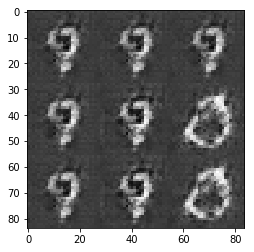

Epoch 2/2... Discriminator Loss: 0.0832... Generator Loss: 10.7688
Epoch 2/2... Discriminator Loss: 0.1265... Generator Loss: 4.1187
Epoch 2/2... Discriminator Loss: 0.1560... Generator Loss: 2.5835


In [84]:
batch_size = 128
z_dim = 1
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/4... Discriminator Loss: 1.7874... Generator Loss: 0.5017
Epoch 1/4... Discriminator Loss: 1.3971... Generator Loss: 0.6871
Epoch 1/4... Discriminator Loss: 1.2481... Generator Loss: 1.3126
Epoch 1/4... Discriminator Loss: 1.2804... Generator Loss: 1.5591
Epoch 1/4... Discriminator Loss: 1.4859... Generator Loss: 1.8076
Epoch 1/4... Discriminator Loss: 1.2784... Generator Loss: 1.3599
Epoch 1/4... Discriminator Loss: 1.2290... Generator Loss: 0.8778
Epoch 1/4... Discriminator Loss: 0.9988... Generator Loss: 1.0446
Epoch 1/4... Discriminator Loss: 1.2481... Generator Loss: 0.5077
Epoch 1/4... Discriminator Loss: 1.0309... Generator Loss: 0.6185


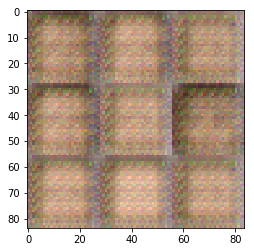

Epoch 1/4... Discriminator Loss: 0.6091... Generator Loss: 1.2573
Epoch 1/4... Discriminator Loss: 1.2905... Generator Loss: 0.3868
Epoch 1/4... Discriminator Loss: 0.9897... Generator Loss: 0.6137
Epoch 1/4... Discriminator Loss: 1.0761... Generator Loss: 0.5467
Epoch 1/4... Discriminator Loss: 0.8850... Generator Loss: 1.3515
Epoch 1/4... Discriminator Loss: 1.6367... Generator Loss: 0.8695
Epoch 1/4... Discriminator Loss: 1.7893... Generator Loss: 0.6851
Epoch 1/4... Discriminator Loss: 1.1948... Generator Loss: 0.8473
Epoch 1/4... Discriminator Loss: 1.8185... Generator Loss: 0.3004
Epoch 1/4... Discriminator Loss: 1.0498... Generator Loss: 0.6407


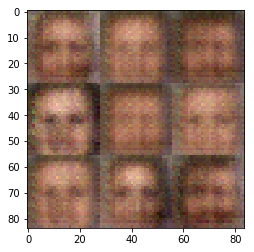

Epoch 1/4... Discriminator Loss: 1.1946... Generator Loss: 0.4925
Epoch 1/4... Discriminator Loss: 1.0658... Generator Loss: 2.2027
Epoch 1/4... Discriminator Loss: 0.8845... Generator Loss: 1.9679
Epoch 1/4... Discriminator Loss: 0.4578... Generator Loss: 1.5487
Epoch 1/4... Discriminator Loss: 0.5573... Generator Loss: 2.3183
Epoch 1/4... Discriminator Loss: 0.9742... Generator Loss: 1.2006
Epoch 1/4... Discriminator Loss: 0.6249... Generator Loss: 1.4840
Epoch 1/4... Discriminator Loss: 1.4898... Generator Loss: 0.3215
Epoch 1/4... Discriminator Loss: 1.5210... Generator Loss: 3.6668
Epoch 1/4... Discriminator Loss: 0.4817... Generator Loss: 1.6141


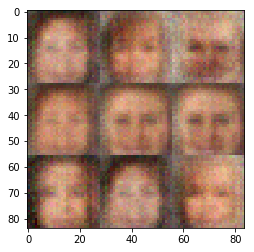

Epoch 1/4... Discriminator Loss: 0.7716... Generator Loss: 1.7803
Epoch 1/4... Discriminator Loss: 1.2620... Generator Loss: 0.5022
Epoch 1/4... Discriminator Loss: 0.8438... Generator Loss: 1.4940
Epoch 1/4... Discriminator Loss: 1.5454... Generator Loss: 0.3222
Epoch 1/4... Discriminator Loss: 0.6264... Generator Loss: 2.1875
Epoch 1/4... Discriminator Loss: 1.2885... Generator Loss: 0.4897
Epoch 1/4... Discriminator Loss: 0.9075... Generator Loss: 0.8609
Epoch 1/4... Discriminator Loss: 0.4825... Generator Loss: 3.1149
Epoch 1/4... Discriminator Loss: 1.2667... Generator Loss: 0.5037
Epoch 1/4... Discriminator Loss: 0.7938... Generator Loss: 1.9928


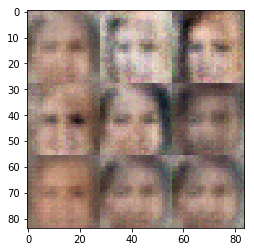

Epoch 1/4... Discriminator Loss: 0.5187... Generator Loss: 1.4239
Epoch 1/4... Discriminator Loss: 0.2792... Generator Loss: 3.0849
Epoch 1/4... Discriminator Loss: 0.8532... Generator Loss: 0.7838
Epoch 1/4... Discriminator Loss: 0.4671... Generator Loss: 1.4426
Epoch 1/4... Discriminator Loss: 1.2214... Generator Loss: 0.4632
Epoch 1/4... Discriminator Loss: 0.4950... Generator Loss: 1.3332
Epoch 1/4... Discriminator Loss: 0.8139... Generator Loss: 1.6553
Epoch 1/4... Discriminator Loss: 1.7496... Generator Loss: 0.2482
Epoch 1/4... Discriminator Loss: 0.7302... Generator Loss: 1.1345
Epoch 1/4... Discriminator Loss: 0.4909... Generator Loss: 1.5600


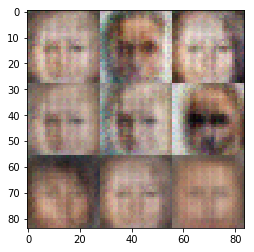

Epoch 1/4... Discriminator Loss: 0.6340... Generator Loss: 1.6793
Epoch 1/4... Discriminator Loss: 1.1603... Generator Loss: 5.8340
Epoch 1/4... Discriminator Loss: 0.6571... Generator Loss: 1.4603
Epoch 1/4... Discriminator Loss: 0.9312... Generator Loss: 0.7459
Epoch 1/4... Discriminator Loss: 0.4369... Generator Loss: 2.0209
Epoch 1/4... Discriminator Loss: 0.5191... Generator Loss: 1.5837
Epoch 1/4... Discriminator Loss: 0.4580... Generator Loss: 4.4823
Epoch 1/4... Discriminator Loss: 0.4489... Generator Loss: 2.5107
Epoch 1/4... Discriminator Loss: 0.4338... Generator Loss: 1.4886
Epoch 1/4... Discriminator Loss: 1.2660... Generator Loss: 3.8199


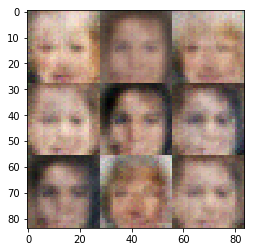

Epoch 1/4... Discriminator Loss: 0.6377... Generator Loss: 2.0024
Epoch 1/4... Discriminator Loss: 0.6891... Generator Loss: 1.8882
Epoch 1/4... Discriminator Loss: 0.6429... Generator Loss: 2.4395
Epoch 1/4... Discriminator Loss: 2.1510... Generator Loss: 0.1498
Epoch 1/4... Discriminator Loss: 0.4490... Generator Loss: 2.4858
Epoch 1/4... Discriminator Loss: 0.5523... Generator Loss: 2.2463
Epoch 1/4... Discriminator Loss: 0.4795... Generator Loss: 1.4930
Epoch 1/4... Discriminator Loss: 1.9603... Generator Loss: 6.3039
Epoch 1/4... Discriminator Loss: 0.3388... Generator Loss: 2.9494
Epoch 1/4... Discriminator Loss: 0.4684... Generator Loss: 1.3563


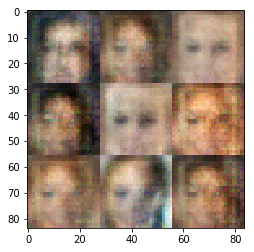

Epoch 1/4... Discriminator Loss: 1.1185... Generator Loss: 0.4968
Epoch 1/4... Discriminator Loss: 0.5825... Generator Loss: 2.4076
Epoch 1/4... Discriminator Loss: 1.3245... Generator Loss: 0.4327
Epoch 1/4... Discriminator Loss: 0.6102... Generator Loss: 4.4858
Epoch 1/4... Discriminator Loss: 0.3670... Generator Loss: 4.1500
Epoch 1/4... Discriminator Loss: 0.5994... Generator Loss: 1.4916
Epoch 1/4... Discriminator Loss: 0.4420... Generator Loss: 2.9428
Epoch 1/4... Discriminator Loss: 0.1534... Generator Loss: 3.4426
Epoch 1/4... Discriminator Loss: 0.3231... Generator Loss: 1.6039
Epoch 1/4... Discriminator Loss: 0.6617... Generator Loss: 0.9454


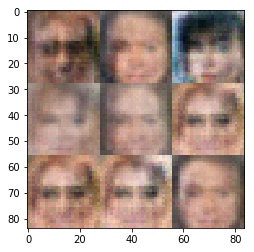

Epoch 1/4... Discriminator Loss: 1.3392... Generator Loss: 0.4894
Epoch 1/4... Discriminator Loss: 1.4724... Generator Loss: 0.3329
Epoch 1/4... Discriminator Loss: 1.4790... Generator Loss: 4.9872
Epoch 1/4... Discriminator Loss: 0.6205... Generator Loss: 1.2317
Epoch 1/4... Discriminator Loss: 0.3212... Generator Loss: 2.0556
Epoch 1/4... Discriminator Loss: 0.1147... Generator Loss: 4.2254
Epoch 1/4... Discriminator Loss: 0.1903... Generator Loss: 2.5285
Epoch 1/4... Discriminator Loss: 0.1333... Generator Loss: 3.9285
Epoch 1/4... Discriminator Loss: 0.5502... Generator Loss: 7.2085
Epoch 1/4... Discriminator Loss: 1.0282... Generator Loss: 8.9663


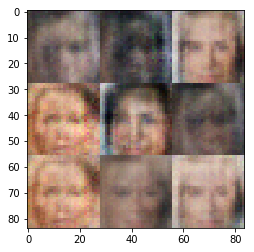

Epoch 1/4... Discriminator Loss: 1.0056... Generator Loss: 0.5826
Epoch 1/4... Discriminator Loss: 1.3428... Generator Loss: 0.3585
Epoch 1/4... Discriminator Loss: 0.2999... Generator Loss: 3.1005
Epoch 1/4... Discriminator Loss: 0.5868... Generator Loss: 2.4965
Epoch 1/4... Discriminator Loss: 0.1972... Generator Loss: 2.8148
Epoch 1/4... Discriminator Loss: 1.4723... Generator Loss: 0.3494
Epoch 1/4... Discriminator Loss: 0.3267... Generator Loss: 3.9673
Epoch 1/4... Discriminator Loss: 1.7672... Generator Loss: 5.1331
Epoch 1/4... Discriminator Loss: 0.3127... Generator Loss: 2.1128
Epoch 1/4... Discriminator Loss: 0.1662... Generator Loss: 3.7788


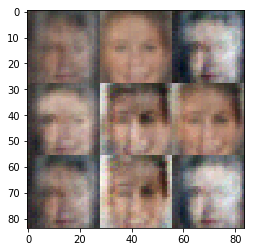

Epoch 1/4... Discriminator Loss: 0.4469... Generator Loss: 1.3885
Epoch 1/4... Discriminator Loss: 0.2309... Generator Loss: 3.6609
Epoch 1/4... Discriminator Loss: 0.4335... Generator Loss: 4.2555
Epoch 1/4... Discriminator Loss: 0.2955... Generator Loss: 3.1536
Epoch 1/4... Discriminator Loss: 0.1035... Generator Loss: 5.2130
Epoch 1/4... Discriminator Loss: 0.5001... Generator Loss: 1.2704
Epoch 1/4... Discriminator Loss: 0.3759... Generator Loss: 8.2564
Epoch 1/4... Discriminator Loss: 0.3753... Generator Loss: 5.0084
Epoch 1/4... Discriminator Loss: 0.2528... Generator Loss: 2.2331
Epoch 1/4... Discriminator Loss: 0.1916... Generator Loss: 3.2256


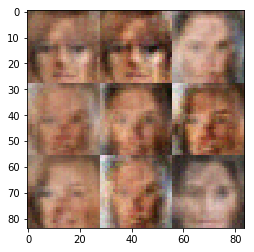

Epoch 1/4... Discriminator Loss: 0.1267... Generator Loss: 4.5261
Epoch 1/4... Discriminator Loss: 0.5384... Generator Loss: 4.1885
Epoch 1/4... Discriminator Loss: 0.3747... Generator Loss: 1.9304
Epoch 1/4... Discriminator Loss: 0.2374... Generator Loss: 2.8604
Epoch 1/4... Discriminator Loss: 0.8873... Generator Loss: 5.9627
Epoch 1/4... Discriminator Loss: 0.2599... Generator Loss: 2.4131
Epoch 1/4... Discriminator Loss: 0.5208... Generator Loss: 1.4027
Epoch 1/4... Discriminator Loss: 0.2022... Generator Loss: 4.5743
Epoch 1/4... Discriminator Loss: 0.5624... Generator Loss: 1.1166
Epoch 1/4... Discriminator Loss: 0.2376... Generator Loss: 5.3619


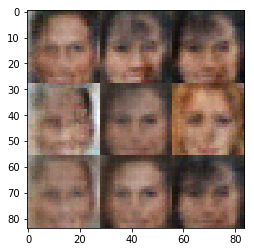

Epoch 1/4... Discriminator Loss: 0.8977... Generator Loss: 7.7054
Epoch 1/4... Discriminator Loss: 0.2656... Generator Loss: 8.6976
Epoch 1/4... Discriminator Loss: 0.3492... Generator Loss: 1.6989
Epoch 1/4... Discriminator Loss: 0.1713... Generator Loss: 3.1767
Epoch 1/4... Discriminator Loss: 0.1817... Generator Loss: 3.3904
Epoch 1/4... Discriminator Loss: 0.1949... Generator Loss: 3.7377
Epoch 1/4... Discriminator Loss: 0.1209... Generator Loss: 4.8342
Epoch 1/4... Discriminator Loss: 0.0878... Generator Loss: 4.7093
Epoch 1/4... Discriminator Loss: 0.0606... Generator Loss: 7.3021
Epoch 1/4... Discriminator Loss: 0.8692... Generator Loss: 0.7807


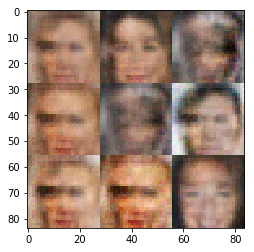

Epoch 1/4... Discriminator Loss: 0.0822... Generator Loss: 3.9928
Epoch 1/4... Discriminator Loss: 0.1136... Generator Loss: 3.4679
Epoch 1/4... Discriminator Loss: 0.0562... Generator Loss: 5.0566
Epoch 1/4... Discriminator Loss: 0.2958... Generator Loss: 1.7741
Epoch 1/4... Discriminator Loss: 0.2567... Generator Loss: 1.8777
Epoch 1/4... Discriminator Loss: 0.5740... Generator Loss: 1.0049
Epoch 1/4... Discriminator Loss: 0.0514... Generator Loss: 5.6400
Epoch 1/4... Discriminator Loss: 0.0205... Generator Loss: 6.7390
Epoch 1/4... Discriminator Loss: 0.2130... Generator Loss: 1.8706
Epoch 1/4... Discriminator Loss: 0.0704... Generator Loss: 4.3580


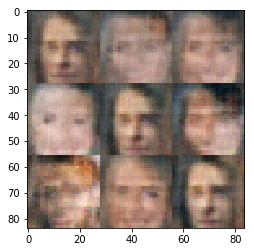

Epoch 1/4... Discriminator Loss: 0.0659... Generator Loss: 3.5406
Epoch 1/4... Discriminator Loss: 0.0792... Generator Loss: 9.2906
Epoch 1/4... Discriminator Loss: 0.2101... Generator Loss: 2.2118
Epoch 1/4... Discriminator Loss: 0.2466... Generator Loss: 2.0549
Epoch 1/4... Discriminator Loss: 0.0314... Generator Loss: 5.3478
Epoch 1/4... Discriminator Loss: 0.0296... Generator Loss: 5.2122
Epoch 1/4... Discriminator Loss: 0.3686... Generator Loss: 4.1206
Epoch 1/4... Discriminator Loss: 0.1118... Generator Loss: 3.9826
Epoch 1/4... Discriminator Loss: 0.2649... Generator Loss: 1.8514
Epoch 1/4... Discriminator Loss: 0.1257... Generator Loss: 3.0261


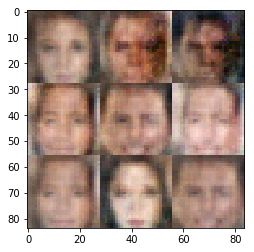

Epoch 1/4... Discriminator Loss: 0.1346... Generator Loss: 5.5409
Epoch 1/4... Discriminator Loss: 0.2290... Generator Loss: 2.6144
Epoch 1/4... Discriminator Loss: 0.2082... Generator Loss: 5.1966
Epoch 1/4... Discriminator Loss: 0.0452... Generator Loss: 4.2906
Epoch 1/4... Discriminator Loss: 0.0810... Generator Loss: 5.8820
Epoch 1/4... Discriminator Loss: 0.1755... Generator Loss: 5.9337
Epoch 1/4... Discriminator Loss: 0.0883... Generator Loss: 3.9922
Epoch 1/4... Discriminator Loss: 0.7060... Generator Loss: 7.8972
Epoch 2/4... Discriminator Loss: 1.0002... Generator Loss: 0.6085
Epoch 2/4... Discriminator Loss: 0.1374... Generator Loss: 6.0369


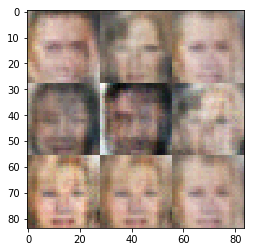

Epoch 2/4... Discriminator Loss: 0.1204... Generator Loss: 3.6737
Epoch 2/4... Discriminator Loss: 0.3774... Generator Loss: 8.5217
Epoch 2/4... Discriminator Loss: 0.0845... Generator Loss: 3.2793
Epoch 2/4... Discriminator Loss: 0.1113... Generator Loss: 2.7261
Epoch 2/4... Discriminator Loss: 0.8292... Generator Loss: 0.8368
Epoch 2/4... Discriminator Loss: 0.0877... Generator Loss: 3.6707
Epoch 2/4... Discriminator Loss: 0.0463... Generator Loss: 7.1231
Epoch 2/4... Discriminator Loss: 0.0958... Generator Loss: 4.2547
Epoch 2/4... Discriminator Loss: 0.0759... Generator Loss: 4.5714
Epoch 2/4... Discriminator Loss: 0.6401... Generator Loss: 0.9591


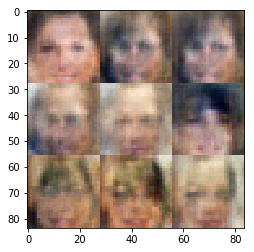

Epoch 2/4... Discriminator Loss: 0.2317... Generator Loss: 9.4940
Epoch 2/4... Discriminator Loss: 0.2035... Generator Loss: 1.9964
Epoch 2/4... Discriminator Loss: 0.0196... Generator Loss: 6.0408
Epoch 2/4... Discriminator Loss: 0.6488... Generator Loss: 1.0080
Epoch 2/4... Discriminator Loss: 0.0285... Generator Loss: 6.6908
Epoch 2/4... Discriminator Loss: 0.4057... Generator Loss: 1.9727
Epoch 2/4... Discriminator Loss: 0.1959... Generator Loss: 2.3831
Epoch 2/4... Discriminator Loss: 0.2131... Generator Loss: 4.1005
Epoch 2/4... Discriminator Loss: 0.8879... Generator Loss: 0.7440
Epoch 2/4... Discriminator Loss: 0.0977... Generator Loss: 4.8356


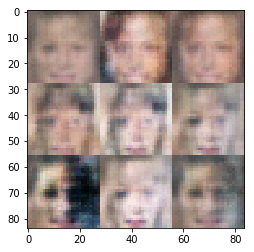

Epoch 2/4... Discriminator Loss: 0.1048... Generator Loss: 5.3086
Epoch 2/4... Discriminator Loss: 0.9745... Generator Loss: 0.6843
Epoch 2/4... Discriminator Loss: 0.4314... Generator Loss: 4.5679
Epoch 2/4... Discriminator Loss: 0.1446... Generator Loss: 2.9336
Epoch 2/4... Discriminator Loss: 0.0737... Generator Loss: 5.4136
Epoch 2/4... Discriminator Loss: 0.2670... Generator Loss: 8.0639
Epoch 2/4... Discriminator Loss: 0.2310... Generator Loss: 8.0599
Epoch 2/4... Discriminator Loss: 0.0844... Generator Loss: 3.1212
Epoch 2/4... Discriminator Loss: 0.1475... Generator Loss: 2.7797
Epoch 2/4... Discriminator Loss: 0.5464... Generator Loss: 1.1965


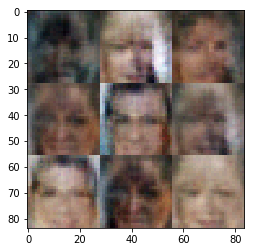

Epoch 2/4... Discriminator Loss: 0.0919... Generator Loss: 2.9769
Epoch 2/4... Discriminator Loss: 0.0963... Generator Loss: 4.2615
Epoch 2/4... Discriminator Loss: 0.2805... Generator Loss: 2.5053
Epoch 2/4... Discriminator Loss: 0.0397... Generator Loss: 5.7942
Epoch 2/4... Discriminator Loss: 0.0662... Generator Loss: 4.7833
Epoch 2/4... Discriminator Loss: 0.3186... Generator Loss: 1.8532
Epoch 2/4... Discriminator Loss: 0.0493... Generator Loss: 6.7647
Epoch 2/4... Discriminator Loss: 2.3486... Generator Loss: 0.1191
Epoch 2/4... Discriminator Loss: 0.3271... Generator Loss: 1.6789
Epoch 2/4... Discriminator Loss: 0.0493... Generator Loss: 5.7595


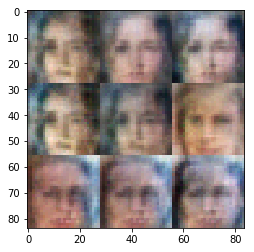

Epoch 2/4... Discriminator Loss: 0.0469... Generator Loss: 7.8577
Epoch 2/4... Discriminator Loss: 0.5896... Generator Loss: 1.0780
Epoch 2/4... Discriminator Loss: 0.1850... Generator Loss: 4.2130
Epoch 2/4... Discriminator Loss: 5.5403... Generator Loss: 9.8933
Epoch 2/4... Discriminator Loss: 0.0444... Generator Loss: 5.0061
Epoch 2/4... Discriminator Loss: 0.8928... Generator Loss: 0.6219
Epoch 2/4... Discriminator Loss: 0.1078... Generator Loss: 2.9747
Epoch 2/4... Discriminator Loss: 0.6187... Generator Loss: 7.2158
Epoch 2/4... Discriminator Loss: 0.0346... Generator Loss: 6.6293
Epoch 2/4... Discriminator Loss: 0.0867... Generator Loss: 3.6481


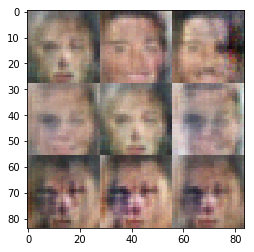

Epoch 2/4... Discriminator Loss: 0.1528... Generator Loss: 2.2172
Epoch 2/4... Discriminator Loss: 0.0214... Generator Loss: 6.6830
Epoch 2/4... Discriminator Loss: 0.1757... Generator Loss: 2.3126
Epoch 2/4... Discriminator Loss: 0.1791... Generator Loss: 2.2082
Epoch 2/4... Discriminator Loss: 1.4199... Generator Loss: 0.3837
Epoch 2/4... Discriminator Loss: 0.0495... Generator Loss: 8.3946
Epoch 2/4... Discriminator Loss: 0.0260... Generator Loss: 7.9486
Epoch 2/4... Discriminator Loss: 0.9870... Generator Loss: 0.6117
Epoch 2/4... Discriminator Loss: 0.2382... Generator Loss: 7.9612
Epoch 2/4... Discriminator Loss: 0.2293... Generator Loss: 2.4732


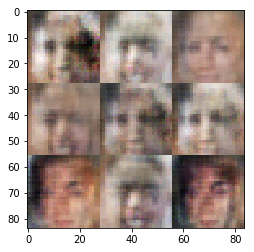

Epoch 2/4... Discriminator Loss: 0.2138... Generator Loss: 9.8761
Epoch 2/4... Discriminator Loss: 0.0531... Generator Loss: 5.6668
Epoch 2/4... Discriminator Loss: 0.0522... Generator Loss: 5.5477
Epoch 2/4... Discriminator Loss: 0.4466... Generator Loss: 1.4165
Epoch 2/4... Discriminator Loss: 0.3005... Generator Loss: 7.3717
Epoch 2/4... Discriminator Loss: 0.0712... Generator Loss: 4.9551
Epoch 2/4... Discriminator Loss: 0.0267... Generator Loss: 6.7499
Epoch 2/4... Discriminator Loss: 0.1553... Generator Loss: 2.3860
Epoch 2/4... Discriminator Loss: 0.1078... Generator Loss: 4.4214
Epoch 2/4... Discriminator Loss: 0.0198... Generator Loss: 5.2596


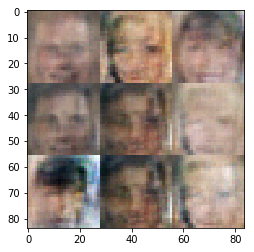

Epoch 2/4... Discriminator Loss: 2.9282... Generator Loss: 7.8878
Epoch 2/4... Discriminator Loss: 0.5249... Generator Loss: 1.3652
Epoch 2/4... Discriminator Loss: 1.4027... Generator Loss: 6.2910
Epoch 2/4... Discriminator Loss: 0.0521... Generator Loss: 4.4368
Epoch 2/4... Discriminator Loss: 0.5394... Generator Loss: 10.8688
Epoch 2/4... Discriminator Loss: 0.1201... Generator Loss: 6.1279
Epoch 2/4... Discriminator Loss: 0.0265... Generator Loss: 7.5396
Epoch 2/4... Discriminator Loss: 1.1357... Generator Loss: 0.4499
Epoch 2/4... Discriminator Loss: 0.0133... Generator Loss: 5.7936
Epoch 2/4... Discriminator Loss: 0.0165... Generator Loss: 8.7313


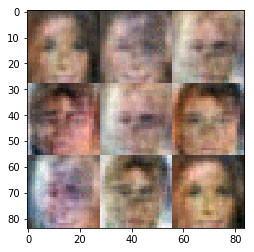

KeyboardInterrupt: 

In [85]:
batch_size = 128
z_dim = 3
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.